# HMM Knockoffs

!!! warning

    HMM Knockoffs are provided as experimental features. fastPHASE HMM knockoffs relies on [fastPHASE.jl](https://github.com/biona001/fastPHASE.jl) which only works on linux and Mac machines (Intel or Rosetta).

## fastPHASE HMM knockoffs

The first example, we generate fastPHASE HMM knockoffs for [genome-wide association studies](https://en.wikipedia.org/wiki/Genome-wide_association_study). This kind of knockoffs is suitable for data *without* population admixture or cryptic relatedness. The methodology is described in the following paper:

> Sesia, Matteo, Chiara Sabatti, and Emmanuel J. Candès. "Gene hunting with hidden Markov model knockoffs." Biometrika 106.1 (2019): 1-18.

If your samples have diverse ancestries and/or extensive relatedness, we recommend those samples to be [filtered out](https://openmendel.github.io/SnpArrays.jl/latest/#SnpArrays.filter), or use SHAPEIT-HMM knockoffs.

In [1]:
# first load packages needed for this tutorial
using Revise
using SnpArrays
using Knockoffs
using Statistics
using Plots
using GLMNet
using Distributions
using Random
using fastPHASE
gr(fmt=:png);

[ Info: Precompiling Knockoffs [878bf26d-0c49-448a-9df5-b057c815d613]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/tDHxD/src/backends.jl:43


### Step 0: Prepare example data

To illustrate we need example PLINK data, which are available in the `data` directory to where `Knockoffs.jl` was installed. 

+ `test.(bed/bim/fam)` are simulated genotypes without missings
+ `mouse.imputed.(bed/bim/fam)` are real genotypes without missing

In [4]:
# path to PLINK data
data_path = normpath(Knockoffs.datadir())

"/Users/biona001/.julia/dev/Knockoffs/data"

### Step 1: Generate Knockoffs

Knockoffs are made using the wrapper function [hmm_knockoff](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.hmm_knockoff). This function does 3 steps sequentially:

1. Run fastPHASE on $\mathbf{X}_{n\times p}$ to estimate $\alpha, \theta, r$ (this step takes 5-10 min for the example data). Note we provide a simple wrapper [fastPHASE.jl](https://github.com/biona001/fastPHASE.jl) which we use here, but the original software, and hence our wrapper, does not support windows machines or Mac with M series processors. 
2. Fit and generate knockoff copies of the HMM 
3. Store knockoffs $\tilde{\mathbf{X}}_{n\times p}$ in binary PLINK format (by default under a new directory called `knockoffs`) and return it as a `SnpArray`

In [9]:
# import PLINK data (test.bed, test.bim, and test.fam)
snpdata = SnpData(joinpath(data_path, "test"))

# estimate fastPHASE HMM parameters
r, θ, α = fastphase_estim_param(snpdata)

seed = 1683238677

This is fastPHASE 1.4.8

Copyright 2005-2006.  University of Washington. All rights reserved.
Written by Paul Scheet, with algorithm developed by Paul Scheet and
Matthew Stephens in the Department of Statistics at the University of
Washington.  Please contact pscheet@alum.wustl.edu for questions, or to
obtain the software visit
http://stephenslab.uchicago.edu/software.html

Total proportion of missing genotypes: 0.000000
1000 diploids below missingness threshold, 0 haplotypes
 data read successfully
1000 diploid individuals, 10000 loci

K selected (by user): 		 12
seed: 			 1
no. EM starts: 		 1
EM iterations: 		 10
no. haps from posterior: 0
NOT using subpopulation labels


 this is random start no. 1 of 1 for the EM...

seed for this start: 1
-12448937.79229315
-9445075.64492578
-8349084.94704032
-7261896.43613014
-6281741.47324536
-5576823.19655063
-5155151.87406101
-4928193.53344398
-4802495.92350104
-4725979.88580363
final loglikelihood: -4676003.575106
iteratio



simulating 0 haplotypes from model: /Users/biona001/.julia/dev/Knockoffs/docs/src/man/tmp1_hapsfrommodel.out


([1.0, 4.27174e-5, 7.86409e-5, 0.0001558163, 0.0001951641, 4.94156e-5, 3.25535e-5, 2.03465e-5, 6.29918e-5, 0.0149603794  …  1.169e-7, 1.0204e-6, 8.9106e-6, 4.31966e-5, 1.70696e-5, 1.57453e-5, 9.3809e-6, 3.60957e-5, 8.69709e-5, 0.0002070214], [0.001 0.001 … 0.001 0.999; 0.001 0.001 … 0.001 0.512408; … ; 0.999 0.999 … 0.999 0.0010000000000000009; 0.999 0.999 … 0.0010000000000000009 0.564578], [0.08277 0.078799 … 0.083905 0.086073; 0.08277 0.078799 … 0.083905 0.086073; … ; 0.08277 0.078799 … 0.083905 0.086073; 0.08277 0.078799 … 0.083905 0.086073])

In [11]:
# Sample HMM knockoffs
Xko = hmm_knockoff(snpdata, r, θ, α)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


1000×10000 SnpArray:
 0x00  0x00  0x03  0x03  0x00  0x03  …  0x03  0x03  0x03  0x02  0x03  0x02
 0x00  0x00  0x02  0x03  0x00  0x00     0x02  0x02  0x02  0x02  0x02  0x02
 0x00  0x00  0x02  0x03  0x02  0x02     0x02  0x03  0x00  0x00  0x02  0x03
 0x00  0x00  0x00  0x00  0x00  0x02     0x02  0x02  0x02  0x02  0x00  0x00
 0x00  0x02  0x02  0x02  0x03  0x02     0x02  0x00  0x00  0x00  0x03  0x03
 0x00  0x00  0x02  0x02  0x02  0x00  …  0x03  0x03  0x03  0x02  0x03  0x02
 0x00  0x00  0x03  0x03  0x00  0x02     0x03  0x00  0x02  0x02  0x03  0x03
 0x02  0x02  0x03  0x02  0x00  0x02     0x03  0x03  0x03  0x02  0x03  0x03
 0x02  0x00  0x02  0x02  0x00  0x02     0x03  0x03  0x02  0x02  0x00  0x00
 0x00  0x03  0x02  0x02  0x03  0x00     0x03  0x03  0x03  0x00  0x00  0x00
 0x00  0x02  0x02  0x03  0x03  0x02  …  0x03  0x03  0x03  0x03  0x00  0x02
 0x02  0x02  0x02  0x02  0x00  0x00     0x02  0x02  0x02  0x02  0x02  0x02
 0x00  0x00  0x03  0x03  0x02  0x02     0x02  0x02  0x02  0x02  0x00  0x00
    

The result `Xko` is a [SnpArray](https://openmendel.github.io/SnpArrays.jl/latest/#SnpArray), a Julia data structure for representing PLINK `.bed` files efficiently. See SnpArrays.jl documentation for more detail.

### Step 2: Examine knockoff statistics

Lets check if the knockoffs "make sense". We compare summary statistics using built-in functions [`compare_pairwise_correlation`](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.compare_pairwise_correlation) and [`compare_correlation`](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.compare_correlation)

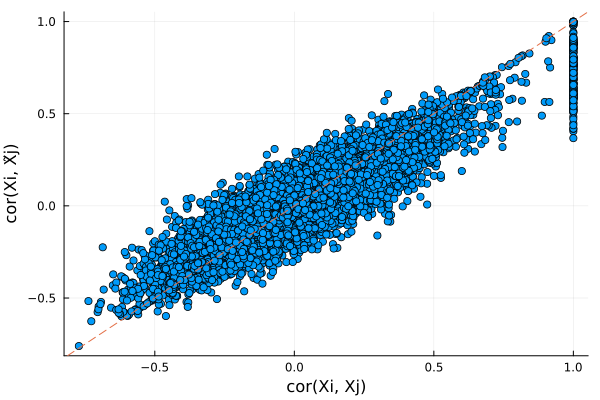

In [12]:
# look at only pairwise correlation between first 200 snps
X = snpdata.snparray
r1, r2 = compare_pairwise_correlation(X, Xko, snps=200)

# make plot
scatter(r1, r2, xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)", legend=false)
Plots.abline!(1, 0, line=:dash)

Plots distribution of $cor(X_j, \tilde{X}_j)$ for all $j$. Ideally, we want $cor(X_j, \tilde{X}_j)$ to be small in magnitude (i.e. $X$ and $\tilde{X}$ is very different). Here the knockoffs are tightly correlated with the original genotypes, so they will likely have low power. 

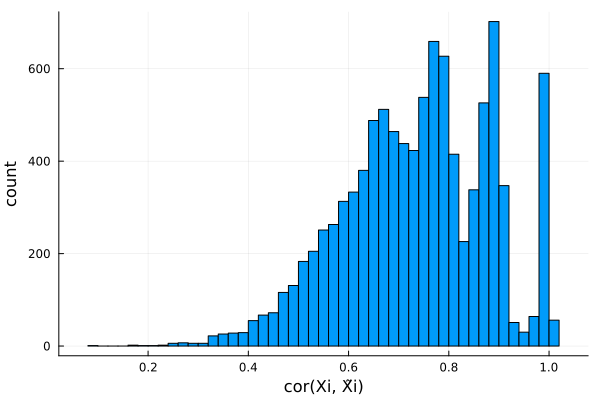

In [14]:
r2 = compare_correlation(X, Xko)
histogram(r2, legend=false, xlabel="cor(Xi, X̃i)", ylabel="count")

## SHAPEIT HMM knockoffs

This page is a tutorial for generating (SHAPEIT) HMM knockoffs, which is good for controlling FDR in the presence of cryptic relatedness and diverse ancestries. The methodology is described in the following paper:

> Sesia, Matteo, et al. "False discovery rate control in genome-wide association studies with population structure." Proceedings of the National Academy of Sciences 118.40 (2021). 

This tutorial closely follows the original [knockoffgwas tutorial](https://msesia.github.io/knockoffgwas/tutorial.html). Currently users need to manually run and process various input/intermediate files, but eventually, we will write native Julia wrappers to circumvent these tedious procedures. Stay tuned. 

!!! note

    It is highly recommended to run this tutorial on linux machines, because RaPID (for detecting IBD segments) only run on linux. Currently users of windows and macOS machines must assume no IBD segments exist. 

### Installation

1. Install [knockoffgwas](https://github.com/msesia/knockoffgwas) and its dependencies
2. Install [qctools](https://www.well.ox.ac.uk/~gav/qctool_v2/documentation/download.html) for converting between VCF and BGEN formats
3. Install [RaPID](https://github.com/ZhiGroup/RaPID) for detecting IBD segments (*this only run on linux*)
4. Install the following Julia packages. Within julia, type
```julia
]add SnpArrays Distributions ProgressMeter MendelIHT VCFTools StatsBase CodecZlib
]add https://github.com/biona001/Knockoffs.jl
```
5. Finally, modify these executable path to the ones installed on your local computer. Here the `partition_exe` is located under the path you installed knockoffgwas: `knockoffgwas/knockoffgwas/utils/partition.R`.

In [1]:
qctools_exe = "/scratch/users/bbchu/qctool/build/release/qctool_v2.0.7"
snpknock2_exe = "/scratch/users/bbchu/knockoffgwas/snpknock2/bin/snpknock2"
rapid_exe = "/scratch/users/bbchu/RaPID/RaPID_v.1.7"
partition_exe = "/scratch/users/bbchu/knockoffgwas/knockoffgwas/utils/partition.R";

### Required inputs

We need multiple input files to generate knockoffs

+ Unphased genotypes in binary PLINK format
+ Phased genotypes in VCF and BGEN format: we will simulate haplotypes, store in VCF format, and convert to BGEN using [qctools](https://www.well.ox.ac.uk/~gav/qctool_v2/documentation/examples/converting.html)
    + Note: knockoffgwas requires only BGEN format, but RaPID requires VCF formats. Hence, the extra conversion
+ Map file (providing different group resolution): since data is simulated, we will generate fake map file
+ IBD segment file (generated by [RaPID](https://github.com/ZhiGroup/RaPID) which requires VCF inputs)
+ Variant partition files (generated by snpknock2, i.e. module 2 of [knockoffgwas](https://github.com/msesia/knockoffgwas)) 
+ Sample and variant QC files

### Simulate genotypes


Our simulation will try to follow
+ Adding population structure (admixture & cryptic relatedness): [New approaches to population stratification in genome-wide association studies](https://www.nature.com/articles/nrg2813)
+ How to simulate siblings: [Using Extended Genealogy to Estimate Components of Heritability for 23 Quantitative and Dichotomous Traits](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1003520)

#### Population structure

Specifically, lets simulate genotypes with 2 populations. We simulate 49700 normally differentiated markers and 300 unusually differentiated markers based on allele frequency difference equal to 0.6. Let $x_{ij}$ be the number of alternate allele count for sample $i$ at SNP $j$ with allele frequency $p_j$. Also let $h_{ij, 1}$ denotype haplotype 1 of sample $i$ at SNP $j$ and $h_{ij, 2}$ the second haplotype. Our simulation model is

$$h_{ij, 1} \sim Bernoulli(p_j), \quad h_{ij, 2} \sim Bernoulli(p_j), \quad x_{ij} = h_{ij, 1} + h_{ij, 2}$$

which is equivalent to  

$$x_{ij} \sim Binomial(2, p_j)$$

for unphased data. The allele frequency is $p_{j} = Uniform(0, 1)$ for normally differentiated markers, and 

$$p_{pop1, j} \sim Uniform(0, 0.4), \quad p_{pop2, j} = p_{pop1, j} + 0.6$$

for abnormally differentiated markers. Each sample is randomly assigned to population 1 or 2. 

#### Sibling pairs

Based on the simulated data above, we can randomly sample pairs of individuals and have them produce offspring. Here, half of all offsprings will be siblings with the other half. This is done by first randomly sampling 2 person to represent parent. Assume they have 2 children. Then generate offspring individuals by copying segments of one parent haplotype directly to the corresponding haplotype of the offspring. This recombination event will produce IBD segments. The number of recombination is 1 or 2 per chromosome, and is chosen uniformly across the chromosome. 

### Step 0: simulate genotypes

Load Julia packages needed for this tutorial

In [2]:
using SnpArrays
using Knockoffs
using DelimitedFiles
using Random
using LinearAlgebra
using Distributions
using ProgressMeter
using MendelIHT
using VCFTools
using StatsBase
using CodecZlib

Load helper functions needed for this tutorial (data simulation + some glue code). It is not crucial to understand what they are doing.  

In [9]:
"""
    simulate_pop_structure(n, p)

Simulate genotypes with K = 2 populations. 300 SNPs will have different allele 
frequencies between the populations, where 50 of them will be causal

# Inputs
- `plinkfile`: Output plink file name. 
- `n`: Number of samples
- `p`: Number of SNPs

# Output
- `x1`: n×p matrix of the 1st haplotype for each sample. Each row is a haplotype
- `x2`: n×p matrix of the 2nd haplotype for each sample. `x = x1 + x2`
- `populations`: Vector of length `n` indicating population membership for eachsample. 
- `diff_markers`: Indices of the differentially expressed alleles.

# Reference
https://www.nature.com/articles/nrg2813
"""
function simulate_pop_structure(n::Int, p::Int)
    # first simulate genotypes treating all samples equally
    x1 = BitMatrix(undef, n, p)
    x2 = BitMatrix(undef, n, p)
    pmeter = Progress(p, 0.1, "Simulating genotypes...")
    @inbounds for j in 1:p
        d = Bernoulli(rand())
        for i in 1:n
            x1[i, j] = rand(d)
            x2[i, j] = rand(d)
        end
        next!(pmeter)
    end
    # assign populations and simulate 300 unually differentiated markers
    populations = rand(1:2, n)
    diff_markers = sample(1:p, 300, replace=false)
    @inbounds for j in diff_markers
        pop1_allele_freq = 0.4rand()
        pop2_allele_freq = pop1_allele_freq + 0.6
        pop1_dist = Bernoulli(pop1_allele_freq)
        pop2_dist = Bernoulli(pop2_allele_freq)
        for i in 1:n
            d = isone(populations[i]) ? pop1_dist : pop2_dist
            x1[i, j] = rand(d)
            x2[i, j] = rand(d)
        end
    end
    return x1, x2, populations, diff_markers
end

"""
    simulate_IBD(h1::BitMatrix, h2::BitMatrix, k::Int)

Simulate recombination events. Parent haplotypes `h1` and `h2` will be used to generate 
`k` children, then both parent and children haplotypes will be returned. 

In offspring simulation, half of all offsprings will be siblings with the other half.
This is done by first randomly sampling 2 samples from to represent parent. Assume they have
2 children. Then generate offspring individuals by copying segments of the parents haplotype
directly to the offspring to represent IBD segments. The number of segments (i.e. places of
recombination) is 1 or 2 per chromosome, and is chosen uniformly across the chromosome. 

# Inputs
- `h1`: `n × p` matrix of the 1st haplotype for each parent. Each row is a haplotype
- `h2`: `n × p` matrix of the 2nd haplotype for each parent. `H = h1 + h2`
- `k`: Total number of offsprings

# Output
- `H1`: `n+k × p` matrix of the 1st haplotype. The first `n` haplotypes are from parents
    and the next `k` haplotypes are the offsprings. Each row is a haplotype
- `H2`: `n+k × p` matrix of the 2nd haplotype. `x = x1 + x2`

# References
https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1003520
"""
function simulate_IBD(h1::BitMatrix, h2::BitMatrix, k::Int)
    n, p = size(h1)
    iseven(k) || error("number of offsprings should be even")
    # randomly designate gender for parents
    sex = bitrand(n)
    male_idx = findall(x -> x == true, sex)
    female_idx = findall(x -> x == false, sex)
    # simulate new samples
    x1 = falses(k, p)
    x2 = falses(k, p)
    fathers = Int[]
    mothers = Int[]
    pmeter = Progress(k, 0.1, "Simulating IBD segments...")
    for i in 1:k
        # assign parents
        dad = rand(male_idx)
        mom = rand(female_idx)
        push!(fathers, dad)
        push!(mothers, mom)
        # recombination
        recombine!(@view(x1[i, :]), @view(x2[i, :]), @view(h1[dad, :]),
                   @view(h2[dad, :]), @view(h1[mom, :]), @view(h2[mom, :]))
        # update progress
        next!(pmeter)
    end
    # combine offsprings and parents
    H1 = [h1; x1]
    H2 = [h2; x2]
    return H1, H2, fathers, mothers
end

function recombination_segments(breakpoints::Vector{Int}, snps::Int)
    start = 1
    result = UnitRange{Int}[]
    for bkpt in breakpoints
        push!(result, start:bkpt)
        start = bkpt + 1
    end
    push!(result, breakpoints[end]+1:snps)
    return result
end

function recombine!(child_h1, child_h2, dad_h1, dad_h2, mom_h1, mom_h2)
    p = length(child_h1)
    recombinations = rand(1:5)
    breakpoints = sort!(sample(1:p, recombinations, replace=false))
    segments = recombination_segments(breakpoints, p)
    for segment in segments
        dad_hap = rand() < 0.5 ? dad_h1 : dad_h2
        mom_hap = rand() < 0.5 ? mom_h1 : mom_h2
        copyto!(@view(child_h1[segment]), @view(dad_hap[segment]))
        copyto!(@view(child_h2[segment]), @view(mom_hap[segment]))
    end
end

function write_plink(outfile::AbstractString, x1::AbstractMatrix, x2::AbstractMatrix)
    n, p = size(x1)
    x = SnpArray(outfile * ".bed", n, p)
    for j in 1:p, i in 1:n
        c = x1[i, j] + x2[i, j]
        if c == 0
            x[i, j] = 0x00
        elseif c == 1
            x[i, j] = 0x02
        elseif c == 2
            x[i, j] = 0x03
        else
            error("matrix entries should be 0, 1, or 2 but was $c!")
        end
    end
    # create .bim file structure: https://www.cog-genomics.org/plink2/formats#bim
    open(outfile * ".bim", "w") do f
        for i in 1:p
            println(f, "1\tsnp$i\t0\t$(100i)\t1\t2")
        end
    end
    # create .fam file structure: https://www.cog-genomics.org/plink2/formats#fam
    open(outfile * ".fam", "w") do f
        for i in 1:n
            println(f, "$i\t1\t0\t0\t1\t-9")
        end
    end
    return nothing
end

function make_partition_mapfile(filename, p::Int)
    map_cM = LinRange(0.0, Int(p / 10000), p)
    open(filename, "w") do io
        println(io, "Chromosome\tPosition(bp)\tRate(cM/Mb)\tMap(cM)")
        for i in 1:p
            println(io, "chr1\t", 100i, '\t', 0.01rand(), '\t', map_cM[i])
        end
    end
end

function make_rapid_mapfile(filename, p::Int)
    map_cM = LinRange(0.0, Int(p / 10000), p)
    open(filename, "w") do io
        for i in 1:p
            println(io, i, '\t', map_cM[i])
        end
    end
end

function process_rapid_output(inputfile, outputfile)
    writer = open(outputfile, "w")
    df = readdlm(inputfile)
    println(writer, "CHR ID1 HID1 ID2 HID2 BP.start BP.end site.start site.end cM FAM1 FAM2")
    for r in eachrow(df)
        chr, id1, id2, hap1, hap2, start_pos, end_pos, genetic_len, start_site, end_site = 
            Int(r[1]), Int(r[2]), Int(r[3]), Int(r[4]), Int(r[5]), Int(r[6]), Int(r[7]),
            r[8], Int(r[9]), Int(r[10])
        println(writer, chr, ' ', id1, ' ', hap1, ' ', id2, ' ', hap2, ' ', 
            start_pos, ' ', end_pos, ' ', start_site, ' ', end_site, ' ', 
            genetic_len, ' ', 1, ' ', 1)
    end
    close(writer)
end

function make_bgen_samplefile(filename, n)
    open(filename, "w") do io
        println(io, "ID_1 ID_2 missing sex")
        println(io, "0 0 0 D")
        for i in 1:n
            println(io, "$i 1 0 1")
        end
    end 
end

make_bgen_samplefile (generic function with 1 method)

Simulate phased data with 2 populations, 49700 usually differentiated markers, and 300 unusually differentiated markers. Then simulate mating, which generates IBD segments. Finally, make unphased data from offspring haplotypes. 

In [10]:
# simulate phased genotypes
Random.seed!(2021)
outfile = "sim"
n = 2000
p = 50000
h1, h2, populations, diff_markers = simulate_pop_structure(n, p)

# simulate random mating to get IBD segments
offsprings = 100
x1, x2 = simulate_IBD(h1, h2, offsprings)

# write phased genotypes to VCF format
write_vcf("sim.phased.vcf.gz", x1, x2)

# write unphased genotypes to PLINK binary format
write_plink(outfile, x1, x2)

# save pop1/pop2 index and unually differentiated marker indices
writedlm("populations.txt", populations)
writedlm("diff_markers.txt", diff_markers)

Simulating genotypes...100%|████████████████████████████| Time: 0:00:01
Writing VCF...100%|█████████████████████████████████████| Time: 0:00:24


### Step 1: Partitions

We need
+ Map file (in particular the (cM) field will determine group resolution)
+ PLINK's bim file
+ QC file (all SNP names that pass QC)
+ output file name

Since data is simulated, there are no genomic map file. Let us generate a fake one. 

In [11]:
# generate fake map file
make_partition_mapfile("sim.partition.map", p)

# also generate QC file that contains all SNPs and all samples
snpdata = SnpData("sim")
snpIDs = snpdata.snp_info[!, :snpid]
sampleIDs = Matrix(snpdata.person_info[!, 1:2])
writedlm("variants_qc.txt", snpIDs)
writedlm("samples_qc.txt", sampleIDs)

Now we run the partition script

In [12]:
plinkfile = "sim"
mapfile = "sim.partition.map"
qc_variants = "variants_qc.txt"
outfile = "sim.partition.txt"
partition(partition_exe, plinkfile, mapfile, qc_variants, outfile)

Mean group sizes: 
      res_7       res_6       res_5       res_4       res_3       res_2 
    1.00000    67.75068   349.65035   694.44444  1351.35135  3333.33333 
      res_1 
10000.00000 
Partitions written to: sim.partition.txt


Process(`Rscript --vanilla /scratch/users/bbchu/knockoffgwas/knockoffgwas/utils/partition.R sim.partition.map sim.bim variants_qc.txt sim.partition.txt`, ProcessExited(0))

### Step 2: Generate Knockoffs

First generate IBD segment files. We need to generate RaPID's required map file

In [13]:
make_rapid_mapfile("sim.rapid.map", p)

Next we run the RaPID software

In [16]:
vcffile = "sim.phased.vcf.gz"
mapfile = "sim.rapid.map"
outfolder = "rapid"
d = 3    # minimum IBD length in cM
w = 3    # number of SNPs per window
r = 10   # number of runs
s = 2    # Minimum number of successes to consider a hit
@time rapid(rapid_exe, vcffile, mapfile, d, outfolder, w, r, s)

# unzip output file
run(pipeline(`gunzip -c ./rapid/results.max.gz`, stdout="./rapid/results.max"))

┌ Info: RaPID command:
│ `/scratch/users/bbchu/RaPID/RaPID_v.1.7 -i sim.phased.vcf.gz -g sim.rapid.map -d 3 -o rapid -w 3 -r 10 -s 2`
└ @ Knockoffs /home/users/bbchu/.julia/packages/Knockoffs/69ZxJ/src/hmm_wrapper.jl:55
┌ Info: Output directory: rapid
└ @ Knockoffs /home/users/bbchu/.julia/packages/Knockoffs/69ZxJ/src/hmm_wrapper.jl:56


Create sub-samples..
Done!
 43.120301 seconds (3.04 k allocations: 159.828 KiB)


Process(`gunzip -c ./rapid/results.max.gz`, ProcessExited(0))

In [17]:
countlines("./rapid/results.max") # d = 3, w = 3, r = 10, s = 9

140

Here we identified 140 IBD segments. Because we only simulated 100 offsprings, and all 2000 parents are unrelated, the "IBD related families" are small. When there are too many segments, one might have to prune the IBD segments so that the families are not too connected. See [this issue](https://github.com/msesia/knockoffgwas/issues/3) for details. 

where the column format is: 
```
<chr_name> <sample_id1> <sample_id2> <hap_id1> <hap_id2> <starting_pos_genomic> <ending_pos_genomic> <genetic_length> <starting_site> <ending_site>
```

Then we need to do some postprocessing to this output, as [described here](https://github.com/msesia/knockoffgwas/issues/2). 

In [22]:
process_rapid_output("./rapid/results.max", "sim.snpknock.ibdmap")

The output looks like follows. The last 5 columns (site.start site.end cM FAM1 FAM2) are not actually currently used. They need to be there (the file should have 12 fields in total), but it doesn't matter what values you put in them.

In [23]:
;head sim.snpknock.ibdmap

CHR ID1 HID1 ID2 HID2 BP.start BP.end site.start site.end cM FAM1 FAM2
1 29 0 2053 0 100 5000000 0 49999 4.9999 1 1
1 64 0 2003 1 100 4712700 0 47126 4.71259 1 1
1 97 1 2051 0 100 5000000 0 49999 4.9999 1 1
1 99 1 2017 0 967300 5000000 9672 49999 4.03278 1 1
1 106 1 2024 1 100 4078800 0 40787 4.07868 1 1
1 151 1 2009 0 100 5000000 0 49999 4.9999 1 1
1 155 1 2069 0 100 5000000 0 49999 4.9999 1 1
1 163 1 2073 1 100 3309000 0 33089 3.30887 1 1
1 231 1 2080 1 1153000 5000000 11529 49999 3.84708 1 1


Next convert VCF file to BGEN format (note: sample file must be saved separately)

In [24]:
# convert VCF to BGEN format
outfile = "sim.bgen"
run(`$qctools_exe -g $vcffile -og $outfile`)

# then save sample file separately
make_bgen_samplefile("sim.sample", n + offsprings)


Welcome to qctool
(version: 2.0.7, revision )

(C) 2009-2017 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,32.2/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "sim.phased.vcf.gz"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 2100
Output GEN file(s):             "sim.bgen"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    2100.
# of samples after filtering:   2100 (0 filtered out).


Processing SNPs                                             :  (50000/?,169.4s,295.2/s)60.3s,275.2/s)
Total: 50000SNPs.

Number of SNPs:
                     -- in input file(s):                 (not computed).
 -- in output file(s):    

Finally, generate HMM knockoffs by running the following code in the command line directly. You may need to adjust file directories and change parameters. 

In [25]:
bgenfile = "sim"
sample_qc = "samples_qc.txt"
variant_qc = "variants_qc.txt"
mapfile = "sim.partition.map"
partfile = "sim.partition.txt"
ibdfile = "sim.snpknock.ibdmap"
K = 10
cluster_size_min = 1000 
cluster_size_max = 10000 
hmm_rho = 1
hmm_lambda = 1e-3 
windows = 0
n_threads = 1
seed = 2021
compute_references = true
generate_knockoffs = true
outfile = "sim.knockoffs"

@time snpknock2(snpknock2_exe, bgenfile, sample_qc, variant_qc, mapfile, partfile, ibdfile, 
    K, cluster_size_min, cluster_size_max, hmm_rho, hmm_lambda, windows, n_threads, 
    seed, compute_references, generate_knockoffs, outfile)

	+----------------------+
	|                      |
	|  SNPKNOCK2, v0.3     |
	|  July 21, 2020       |
	|  Matteo Sesia        |
	|                      |
	+----------------------+

Copyright (C) 2020 Stanford University.
Distributed under the GNU GPLv3 open source license.

Use --help for more information.

Command line arguments:
  --bgen sim
  --keep samples_qc.txt
  --extract variants_qc.txt
  --map sim.partition.map
  --part sim.partition.txt
  --ibd sim.snpknock.ibdmap
  --K 10
  --cluster_size_min 1000
  --cluster_size_max 10000
  --hmm-rho 1
  --hmm-lambda 0.001
  --windows 0
  --n_threads 1
  --seed 2021
  --compute-references
  --generate-knockoffs
  --out ./knockoffs/sim.knockoffs

Requested operations:
  --compute-references
  --generate_knockoffs



┌ Info: snpknock2 command:
│ `/scratch/users/bbchu/knockoffgwas/snpknock2/bin/snpknock2 --bgen sim --keep samples_qc.txt --extract variants_qc.txt --map sim.partition.map --part sim.partition.txt --ibd sim.snpknock.ibdmap --K 10 --cluster_size_min 1000 --cluster_size_max 10000 --hmm-rho 1 --hmm-lambda 0.001 --windows 0 --n_threads 1 --seed 2021 --compute-references --generate-knockoffs --out ./knockoffs/sim.knockoffs`
└ @ Knockoffs /home/users/bbchu/.julia/packages/Knockoffs/69ZxJ/src/hmm_wrapper.jl:100
┌ Info: Output directory: /home/users/bbchu/hmm/knockoffs
└ @ Knockoffs /home/users/bbchu/.julia/packages/Knockoffs/69ZxJ/src/hmm_wrapper.jl:101



--------------------------------------------------------------------------------
Loading metadata
--------------------------------------------------------------------------------
Loading sample information from:
  sim.sample
Loading legend from:
  sim.bim
Loading partitions from:
  sim.partition.txt
Loading IBD segments from:
  sim.snpknock.ibdmap
Loaded 140 IBD segments.

Printing summary of 1 windows:
     0: 0--50000
Summary of metadata for chromosome 1:
  number of samples (after | before filtering) : 2100 | 2100
  number of SNPs (after | before filtering)    : 50000 | 50000
  number of variant partitions                 : 7
  size of genomic windows                      : whole-chromosome
  number of IBD segments                       : 140


--------------------------------------------------------------------------------
Kinship (using only haplotype data)
--------------------------------------------------------------------------------
Reached 1
Chromosome 1 will be loaded from:


Bifurcating K-means
Smallest allowed cluster size: 1000
 step	 cluster	    size	    left	   right	accepted
Bifurcating K-means completed after 0 steps.
Number of clusters: 1.



====================================================================================================|

Reached 2
Individual global references written to:
  ./knockoffs/sim.knockoffs_lref.txt

Individual local references written to:
  ./knockoffs/sim.knockoffs_ref.txt


--------------------------------------------------------------------------------
Knockoffs for chromosome 1
--------------------------------------------------------------------------------
Chromosome 1 will be loaded from:
  haplotype file            : sim
  haplotype file format     : bgen
  sample file               : sim.sample
  legend file               : sim.bim
  map file                  : sim.partition.map
  sample filter file        : samples_qc.txt
  variant filter file       : variants_qc.txt
  number of SNPs            : 50000
  number of windows         : 1
  number of haplotypes      : 4200

Loading data for chromosome 1
Reading BGEN file using 1 thread:
|...................................................

Process(`/scratch/users/bbchu/knockoffgwas/snpknock2/bin/snpknock2 --bgen sim --keep samples_qc.txt --extract variants_qc.txt --map sim.partition.map --part sim.partition.txt --ibd sim.snpknock.ibdmap --K 10 --cluster_size_min 1000 --cluster_size_max 10000 --hmm-rho 1 --hmm-lambda 0.001 --windows 0 --n_threads 1 --seed 2021 --compute-references --generate-knockoffs --out ./knockoffs/sim.knockoffs`, ProcessExited(0))

### Step 3: Examine Generated Knockoffs

The generated knockoffs are saved in binary PLINK format, we can import it using SnpArrays

In [26]:
x = SnpArray("knockoffs/sim.knockoffs_res0.bed")

2100×100000 SnpArray:
 0x03  0x03  0x02  0x02  0x03  0x03  …  0x02  0x02  0x02  0x03  0x03  0x03
 0x02  0x02  0x03  0x03  0x00  0x02     0x02  0x02  0x03  0x03  0x02  0x03
 0x02  0x02  0x02  0x02  0x02  0x02     0x03  0x03  0x02  0x02  0x03  0x03
 0x00  0x03  0x02  0x02  0x02  0x02     0x03  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x00  0x00  0x03  0x02     0x02  0x02  0x03  0x03  0x03  0x03
 0x02  0x02  0x02  0x02  0x02  0x02  …  0x03  0x03  0x03  0x02  0x03  0x03
 0x02  0x00  0x00  0x00  0x02  0x02     0x03  0x00  0x02  0x02  0x03  0x03
 0x02  0x02  0x02  0x02  0x00  0x02     0x02  0x02  0x02  0x03  0x03  0x03
 0x02  0x03  0x02  0x02  0x03  0x03     0x02  0x02  0x02  0x00  0x03  0x03
 0x02  0x02  0x02  0x02  0x02  0x00     0x02  0x02  0x02  0x02  0x03  0x03
 0x03  0x00  0x02  0x03  0x02  0x03  …  0x02  0x02  0x02  0x02  0x03  0x03
 0x00  0x03  0x03  0x02  0x02  0x02     0x03  0x03  0x02  0x02  0x03  0x03
 0x02  0x02  0x03  0x03  0x03  0x03     0x00  0x02  0x02  0x02  0x03  0x03
   

Notice there are 100k SNPs: the original 50k SNPs and their knockoffs. Reading the SNP names will tell us which are the originals:

In [27]:
snpid = SnpData("knockoffs/sim.knockoffs_res0").snp_info.snpid

100000-element Vector{String}:
 "snp1.k"
 "snp1"
 "snp2"
 "snp2.k"
 "snp3.k"
 "snp3"
 "snp4.k"
 "snp4"
 "snp5.k"
 "snp5"
 "snp6"
 "snp6.k"
 "snp7"
 ⋮
 "snp49995"
 "snp49995.k"
 "snp49996.k"
 "snp49996"
 "snp49997.k"
 "snp49997"
 "snp49998.k"
 "snp49998"
 "snp49999"
 "snp49999.k"
 "snp50000.k"
 "snp50000"

### Step 4: Model selection with knockoffs

Tutorial for this part coming soon! Basically, one constructs a `SnpLinAlg`, feed that into [MendelIHT.jl](https://github.com/OpenMendel/MendelIHT.jl), and calculate knockoff statistics afterwards using built-in functions like `coefficient_diff` and `threshold`.

+ `SnpLinAlg` performs compressed linear algebra (often faster than double precision BLAS)
+ `MendelIHT.jl` is a very efficient implementation of the iterative hard thresholding algorithm. For model selection, IHT is known to be superior to standard LASSO, elastic net, and MCP solvers. 

In [28]:
xla = SnpLinAlg{Float64}(x, center=true, scale=true, impute=true)

2100×100000 SnpLinAlg{Float64}:
  1.76602    1.68237   -0.311698  …   1.20757    0.0817861   0.12776
  0.316766   0.246784   1.13646       1.20757  -12.1861      0.12776
  0.316766   0.246784  -0.311698     -0.22433    0.0817861   0.12776
 -1.13249    1.68237   -0.311698      1.20757    0.0817861   0.12776
  1.76602    1.68237   -1.75985       1.20757    0.0817861   0.12776
  0.316766   0.246784  -0.311698  …  -0.22433    0.0817861   0.12776
  0.316766  -1.1888    -1.75985      -0.22433    0.0817861   0.12776
  0.316766   0.246784  -0.311698      1.20757    0.0817861   0.12776
  0.316766   1.68237   -0.311698     -1.65623    0.0817861   0.12776
  0.316766   0.246784  -0.311698     -0.22433    0.0817861   0.12776
  1.76602   -1.1888    -0.311698  …  -0.22433    0.0817861   0.12776
 -1.13249    1.68237    1.13646      -0.22433    0.0817861   0.12776
  0.316766   0.246784   1.13646      -0.22433    0.0817861   0.12776
  ⋮                               ⋱                         
 -1.13249 